In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.optimize import curve_fit,minimize,fmin
import numpy as np
import matplotlib 
import pickle as pkl  
np.set_printoptions(suppress=True)
plt.rc('text', usetex=True)
%matplotlib inline

dataDir = "../data/"
imageDir = "../images/"

In [2]:
# Loading data
menSeries = pd.read_pickle(dataDir + "pkls/menSeries.pkl")
fluSeries = pd.read_pickle(dataDir + "pkls/fluSeries.pkl")
ausPop = pd.read_pickle(dataDir + "pkls/ausPop.pkl")

In [3]:
import os
if os.path.isfile(dataDir + "pkls/flu_menSIIRParams.pkl"):
    flu_menParams = pkl.load(open(dataDir + "pkls/flu_menSIIRParams.pkl", "rb"))
else:
    flu_menParams = {}
    
menParams = pkl.load(open(dataDir + "pkls/menSIRParams.pkl", "rb"))
fluParams = pkl.load(open(dataDir + "pkls/fluSIRParams.pkl", "rb"))

In [4]:
print(menParams.keys())
print(fluParams.keys())

dict_keys([2017, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])
dict_keys([2017, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])


In [5]:
# Evaluation time
from datetime import datetime # Library for datetime format
from dateutil import relativedelta # Library to calculate delta time from date

year = 2016
startdate = str(year) + '-01'
enddate = str(year) + '-12'


date_format = "%Y-%m"
sd = datetime.strptime(startdate, date_format)
ed = datetime.strptime(enddate, date_format)

n_months = relativedelta.relativedelta(ed, sd) # Number of months (delta time)
print(n_months)

relativedelta(months=+11)


In [6]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 1
t_range = np.arange(t_start, t_end+t_inc, t_inc)


In [7]:
# Initial conditions
SIIR0 = np.zeros(9)
SIIR0[1] = (fluSeries[startdate])
SIIR0[2] = (menSeries[startdate])
SIIR0[0] = ausPop[year] - np.sum(SIIR0[1:8])

fluMenSeries = np.concatenate((fluSeries[startdate:enddate].values,menSeries[startdate:enddate].values))

In [8]:
# Defining SIIR isolated equations
def SIIR_eqs(SIIR0,t,beta1,beta2, delta1, delta2, beta1prime, beta2prime, delta1prime, delta2prime):
    #beta1, beta2, delta1, delta2, beta1prime, beta2prime, delta1prime, delta2prime = params
    SSi, ISi, SIi, IIi, RSi, SRi, RIi, IRi, RRi = SIIR0
    
    N = np.sum(SIIR0)
    
    SS = -SSi * beta1 * (ISi + IIi + IRi) / N - SSi * beta2 * (SIi + IIi + RIi) / N
    SI = beta2*SSi*(SIi + IIi + RIi)/N - beta1prime*SIi*(ISi + IIi + IRi)/N - delta2*SIi 
    SR = delta2 * SIi - SRi * beta1 * (ISi + IIi + IRi)/N
    IS = SSi * beta1 * (ISi + IIi + IRi) / N - delta1 * ISi - ISi * beta2prime * (SIi + IIi + RIi) / N
    II = ISi * beta2prime * (SIi + IIi + RIi) / N + SIi * beta1prime * (ISi + IIi + IRi) / N - delta1prime * IIi - delta2prime * IIi
    IR = SRi * beta1 * (ISi + IIi + IRi) / N + delta2prime * IIi - delta1 * IRi
    RS = delta1 * ISi - RSi * beta2 * (SIi + IIi + RIi) / N
    RI = RSi * beta2 * (SIi + IIi + RIi) / N + delta1prime * IIi - delta2 * RIi
    RR = delta1 * IRi + delta2 * RIi

    return SS, IS, SI, II, RS, SR, RI, IR, RR

# Fitting function from infected data and I state on SIR model
def fitSIIR(t, beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int):
    sir_res = spi.odeint(SIIR_eqs,SIIR0,t,args=(beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int)) 
    I1 = sir_res[:,1] + sir_res[:,3] + sir_res[:,7] 
    I2 = sir_res[:,2] + sir_res[:,3] + sir_res[:,6]
    return I1,I2

def normMSE(data,model):
    n = len(data)
    mse = ((data-model)**2).sum()
    nmse = mse/(n*(data.sum()/n)*(model.sum()/n))

    return nmse

def fitErrorSIIR(params):
    beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int = params

    params_np = np.array(params)
    k = 1 # penalization
    if np.any(params_np<0):
        k = 1000000
    I1,I2 = fitSIIR(t_range, beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int)
    sim = [normMSE(fluSeries[startdate:enddate],I1),normMSE(menSeries[startdate:enddate],I2)]
    
    return k * np.linalg.norm(sim)

In [9]:
p0=[fluParams[year][0],menParams[year][0],fluParams[year][1],menParams[year][1],
    fluParams[year][0],menParams[year][0],fluParams[year][1],menParams[year][1]]

#COBYLA
#params = minimize(fitErrorSIIR,p0,options={'maxiter':10000},
#        bounds=((0,None),(0,None),(0,None),(0,None),
#               (0,None),(0,None),(0,None),(0,None)))

answ=fmin(fitErrorSIIR,p0,full_output=1,maxiter=10000)
params=answ[0]
bestscore=answ[1]
print(params,bestscore)

Optimization terminated successfully.
         Current function value: 562073.130291
         Iterations: 1329
         Function evaluations: 2041
[  14.23654997   -0.07718273   13.68615333    0.44691822   82.57120709
   20.70246869  164.90335766 -162.40129416] 562073.130290817


In [10]:
beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int = params
I1,I2 = fitSIIR(t_range, beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int)
score = [normMSE(fluSeries[startdate:enddate],I1),normMSE(menSeries[startdate:enddate],I2)]

In [11]:
flu_menParams[year] = [beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int, 
                       bestscore,score[0],score[1]]
pkl.dump(flu_menParams, open(dataDir + 'pkls/flu_menSIIRParams.pkl','wb'))

# Evaluation 

In [12]:
# Defining SIR isolated equations
def SIR_eqs(SIR0,t, beta, gamma):
    S0=SIR0[0]
    I0=SIR0[1]
    R0=SIR0[2]

    S = - beta * S0 * I0/ausPop[year]
    I = (beta * S0 * I0/ausPop[year]) - gamma * I0
    R = gamma * I0

    return (S,I,R)

# Fitting function from infected data and I state on SIR model
def fitSIR(t, beta, gamma):
    return spi.odeint(SIR_eqs,SIR0,t_range,args=(beta,gamma))[:,1] 

## Influenza (isolated)

In [13]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 0.01
t_eval = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - fluSeries[startdate])
I0 = (fluSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [14]:
def fluSIRSim(beta,gamma):    
    return spi.odeint(SIR_eqs,SIR0,t_eval,args=(beta,gamma))

In [15]:
betaFlu = fluParams[year][0]
gammaFlu = fluParams[year][1]
SIRflu = fluSIRSim(betaFlu,gammaFlu)
Sflu = SIRflu[:,0]
Iflu = SIRflu[:,1]
Rflu = SIRflu[:,2]

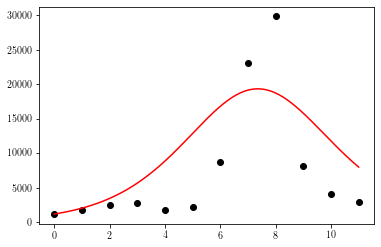

In [16]:
plt.plot(t_range[:n_months.months+1], fluSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,Iflu,'-r',label="Infected fit")
plt.show()
plt.close()

## Meningococcal (isolated)

In [17]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 0.01
t_eval = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - menSeries[startdate])
I0 = (menSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [18]:
def menSIRSim(beta,gamma):    
    return spi.odeint(SIR_eqs,SIR0,t_eval,args=(beta,gamma))

In [19]:
betaMen = menParams[year][0]
gammaMen = menParams[year][1]

SIRmen = menSIRSim(betaMen,gammaMen)
Smen = SIRmen[:,0]
Imen = SIRmen[:,1]
Rmen = SIRmen[:,2]

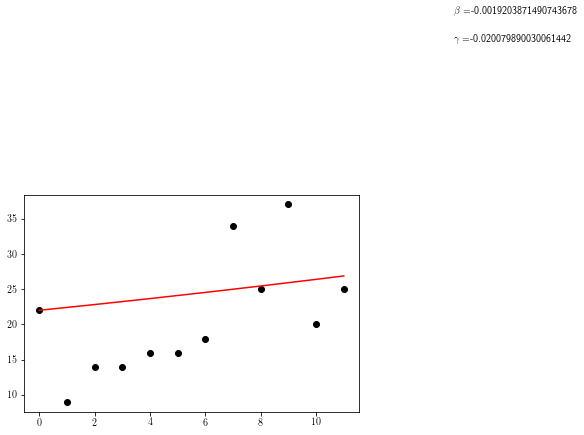

In [20]:

plt.plot(t_range[:n_months.months+1], menSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,Imen,'-r',label="Infected fit")
plt.text(15, 60, r'$\gamma = $' + str(gammaMen))
plt.text(15, 64, r'$\beta = $' + str(betaMen))
plt.show()
plt.close()

## Influenza / Meningococcal (interactive)

In [21]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 0.01
t_eval = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
SIIR0 = np.zeros(9)
SIIR0[1] = (fluSeries[startdate])
SIIR0[2] = (menSeries[startdate])
SIIR0[0] = ausPop[year] - np.sum(SIIR0[1:8])

In [22]:
def menfluSIIRSim(beta1,beta2,gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int):    
    return spi.odeint(SIIR_eqs,SIIR0,t_eval,args=(beta1,beta2, gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int)) 

In [23]:
SIIR = menfluSIIRSim(beta1,beta2,gamma1, gamma2, beta1int, beta2int, gamma1int, gamma2int)
I1 = SIIR[:,1] + SIIR[:,3] + SIIR[:,7] 
I2 = SIIR[:,2] + SIIR[:,3] + SIIR[:,6]
 

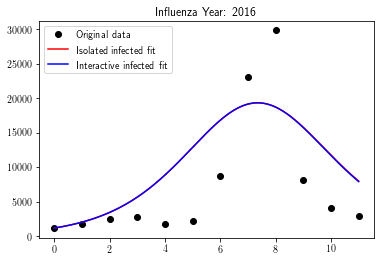

In [24]:
# Influenza

plt.plot(t_range[:n_months.months+1], fluSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,Iflu,'-r',label="Isolated infected fit")
plt.plot(t_eval,I1,'-b',label="Interactive infected fit")
plt.legend()
plt.title("Influenza Year: " + str(year))
plt.savefig(imageDir + "flu_menInteractive/fluInteractive_" + str(year) + ".png" )
plt.show()
plt.close()

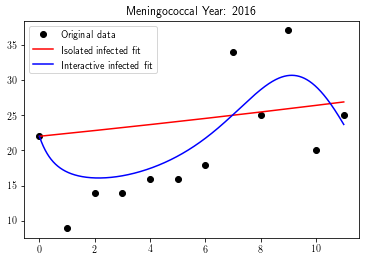

In [25]:
# Meningococcal
plt.plot(t_range[:n_months.months+1], menSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,Imen,'-r',label="Isolated infected fit")
plt.plot(t_eval,I2,'-b',label="Interactive infected fit")
plt.legend()
plt.title("Meningococcal Year: " + str(year))
plt.savefig(imageDir + "flu_menInteractive/menInteractive_" + str(year) + ".png" )
plt.show()
plt.close()

In [26]:
params = (beta1,beta2,gamma1,gamma2,beta1int,beta2int,gamma1int, gamma2int)
print(params)
print(betaFlu,betaMen,gammaFlu,gammaMen)

(14.23654997189014, -0.07718273143908555, 13.686153326838859, 0.4469182182187734, 82.57120708976628, 20.702468694422016, 164.9033576571461, -162.40129416031914)
14.199845208468432 -0.0019203871490743678 13.651995896143694 -0.020079890030061442
